In [2]:
!pip install opendatasets --upgrade --quiet

import pandas as pd
import os
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images'
# Using opendatasets let's download the data sets
# od.download(dataset)
# # {"username":"kganeshv","key":"224eab20b74a0a68fc7194190f513131"}


[notice] A new release of pip is available: 23.1 -> 24.0
[notice] To update, run: python3.9 -m pip install --upgrade pip


## Fine-tuning CNN for AI-generated Image Detection
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known CNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
dataset_dir = "cifake-real-and-ai-generated-synthetic-images" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: cifake-real-and-ai-generated-synthetic-images


In [5]:
# Check if GPUs are available for training
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


Larger batch sizes are expected to result in significantly longer training times, especially with a substantial training set of 100,000 images. However, the compact size of the images effectively reduces the impact on training duration.

In [7]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# Constant values that will be shared by all the models
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

### Model Building

All the models share the same architecture for a fair comparison: the input layer, followed by the base model with pre-trained weights from the imagenet, then a few dense layers, and then a unit output with a sigmoid activation function.

Training is conducted with early stopping criteria monitoring the validation loss, and the best weights will be restored once the training is completed.

In [8]:
Net_base_model = tf.keras.applications.ResNet101V2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
Net_base_model.trainable = True


inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = Net_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256,
          kernel_regularizer = regularizers.l2(0.01),
          activity_regularizer = regularizers.l1(0.01),
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
Net_model = tf.keras.Model(inputs, outputs)

# Compile the model
Net_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
Net_model.summary()

171317808/171317808 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448

In [9]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using Net50...")
ResNet_model_history = Net_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using Net50...
Epoch 1/100
200/200 [==============================] - 45s 142ms/step - loss: 1.5530 - accuracy: 0.8557 - precision: 0.8724 - recall: 0.8332 - val_loss: 0.7573 - val_accuracy: 0.8742 - val_precision: 0.9705 - val_recall: 0.7719
Epoch 2/100
200/200 [==============================] - 26s 127ms/step - loss: 0.4682 - accuracy: 0.9245 - precision: 0.9220 - recall: 0.9274 - val_loss: 0.5519 - val_accuracy: 0.8249 - val_precision: 0.7428 - val_recall: 0.9941
Epoch 3/100
200/200 [==============================] - 26s 128ms/step - loss: 0.2692 - accuracy: 0.9379 - precision: 0.9324 - recall: 0.9442 - val_loss: 0.2502 - val_accuracy: 0.9340 - val_precision: 0.9653 - val_recall: 0.9004
Epoch 4/100
200/200 [==============================] - 26s 128ms/step - loss: 0.2006 - accuracy: 0.9462 - precision: 0.9423 - recall: 0.9505 - val_loss: 0.2087 - val_accuracy: 0.9344 - val_precision: 0.9323 - val_recall: 0.9367
Epoch 5/100
200/200 [===========

In [10]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = Net_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 2s 40ms/step - loss: 0.1714 - accuracy: 0.9515 - precision: 0.9564 - recall: 0.9461
Val Loss: 0.1714
Val Accuracy: 0.9515
Val Precision: 0.9564
Val Recall: 0.9461


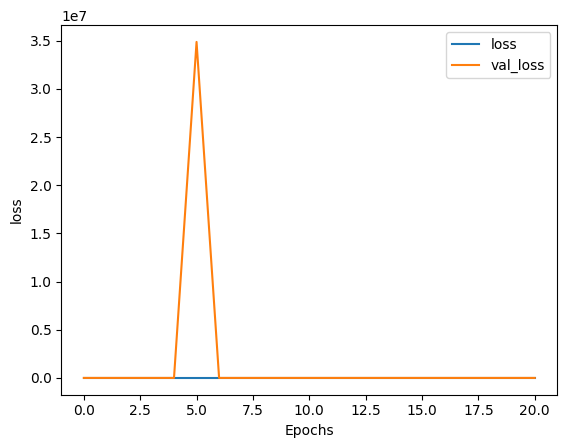

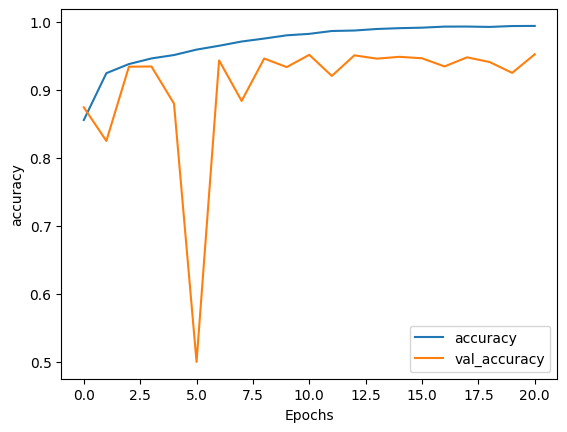

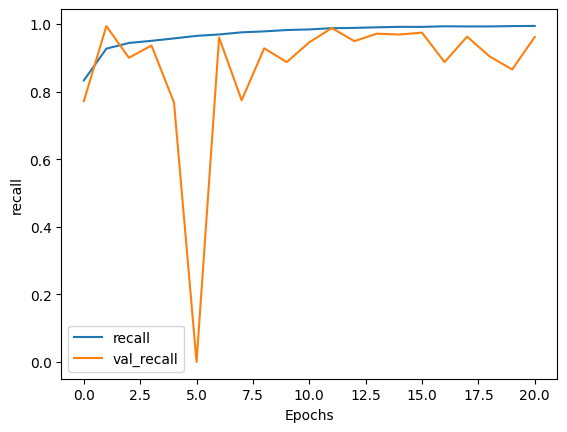

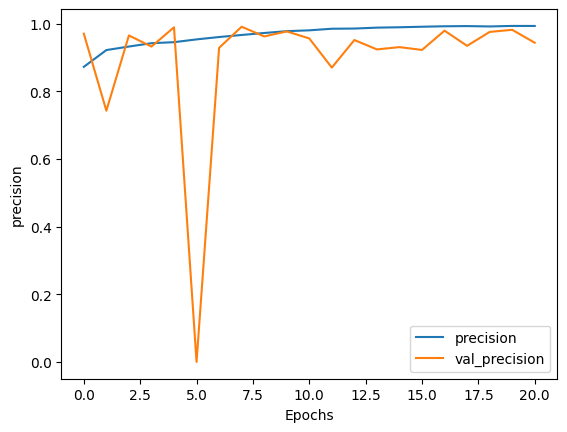

In [12]:
# Plot error rates and metric rates
plot_metrics(ResNet_model_history, 'loss')
plot_metrics(ResNet_model_history, 'accuracy')
plot_metrics(ResNet_model_history, 'recall')
plot_metrics(ResNet_model_history, 'precision')
